In [1]:
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as mean_squared_error
import math

In [2]:
df = pd.read_stata("../data/variables_productos_primarios.dta",index_col="fecha")
df = df.drop(["mes","anio"],axis=1)
df["pp"] = df.pp / 1_000_000

In [3]:
train_df = df[:-6].copy()
test_df = df.copy()

In [4]:
y = train_df["pp"]
model = pm.auto_arima(
                    y=y, start_p=1, start_q=1,
                    test='adf',       # use adftest to find optimal 'd'
                    max_p=9, max_q=9, # maximum p and q
                    m=12,              # periodicity of 12 months as the data timeline is in months
                    d=1,           # let the model determine 'd'
                    seasonal=True,   # Seasonality
                    start_P=0, 
                    D=1, 
                    max_order=20,
                    with_intercept=True,
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=2791.744, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=2747.006, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2789.744, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=2790.154, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=2734.829, Time=0.81 sec
 ARIMA(1,1,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(1,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=2736.497, Time=0.71 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=2734.419, Time=1.05 sec
 ARIMA(2,1,0)(1,1,0)[12] intercept   : AIC=2747.116, Time=0.42 sec
 ARIMA(2,1,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(2,1,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(3,1,0)(2,1,0)[12] intercept   : AIC=2734.0

In [5]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  209
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1360.019
Date:                            Mon, 16 Oct 2023   AIC                           2732.039
Time:                                    21:24:27   BIC                           2751.707
Sample:                                01-01-2005   HQIC                          2740.001
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1652      0.063     -2.611      0.009      -0.289      -0.041
ar.L2         -0.1301      0.074     -1.766      0.077      -0.275       0.014
ar.L3         -0.1114      0.074     -1.502      0.133      -0.257       0.034
ar.S.L12      -0.5758      0.080     -7.196      0.000      -0.733      -0.419
ar.S.L24      -0.2793      0.079     -3.546      0.000      -0.434      -0.125
sigma2      6.106e+04   6449.769      9.467      0.000    4.84e+04    7.37e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.95   Prob(JB):                         0.49
Heteroskedasticity (H):               1.23   Skew:                             0.20
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

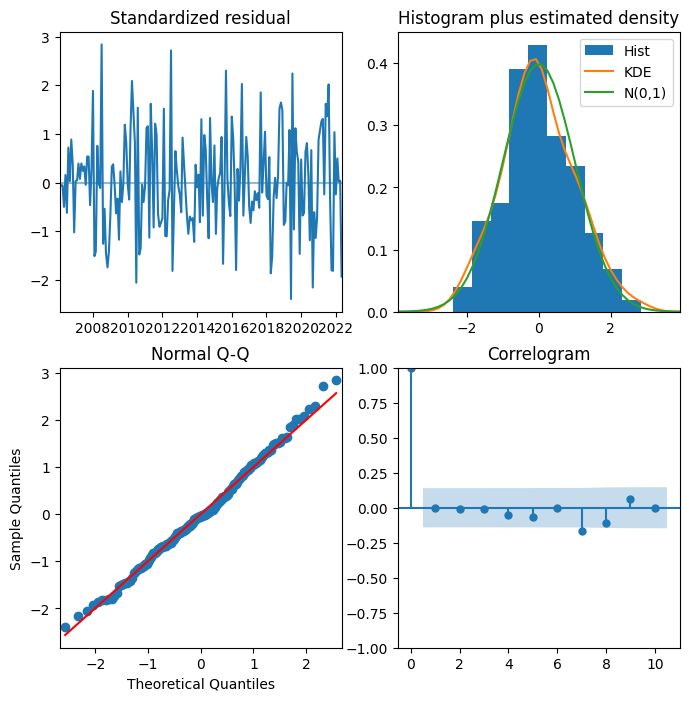

In [6]:
model.plot_diagnostics(figsize=(8,8))
plt.show()

In [7]:
forecast, confint = model.predict(n_periods=6, return_conf_int=True)
forecast = pd.concat([model.fittedvalues(), forecast])
forecast

2005-01-01       0.000000
2005-02-01     505.124108
2005-03-01     498.635091
2005-04-01     652.811232
2005-05-01     935.607768
                 ...     
2022-07-01    2245.628899
2022-08-01    2428.330974
2022-09-01    2070.171433
2022-10-01    1856.058568
2022-11-01    1542.351480
Length: 215, dtype: float64

In [8]:
forecast, confint = model.predict(n_periods=6, return_conf_int=True)

obs_pred_df = pd.DataFrame({"observado":train_df["pp"],
                            "prediccion": pd.concat([model.fittedvalues(), forecast])})
plot_predicc_obs_exog = go.Figure()
# plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["observado"], name = "Observación"))
plot_predicc_obs_exog.add_trace(go.Scatter(x=test_df.index, y = test_df["pp"], name = "Observación"))
plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["prediccion"], name = "Predicción"))
plot_predicc_obs_exog.add_vline(x = obs_pred_df.index[-6], line_width=3, line_dash="dash", line_color="green")
plot_predicc_obs_exog.update_layout(template = None, title_text =f"Testeo modelo para \"pp\"<br><sup>{model}",
font_family = "georgia")
plot_predicc_obs_exog.show()

In [9]:
my_order = model.order #se consigue la estacionariedad
my_seasonal_order = model.seasonal_order
sarima_fut = SARIMAX(test_df[["pp"]],
                    #  exog=X, 
                     order = my_order, seasonal_order=my_seasonal_order) #!!!
model_fit = sarima_fut.fit()
forecast = model_fit.forecast(6, alpha = .1)
forecast = pd.concat([model_fit.fittedvalues, forecast])
ic = model_fit.get_forecast(6,alpha = .1, 
                            # exog = X_new
                            ).conf_int().rename({f"lower pp": "lower", f"upper pp":"upper"},axis=1)
forecast_test_df = pd.DataFrame({"prediccion":forecast,
                                 "observado": test_df["pp"],})
forecast_test_df = pd.concat([forecast_test_df, ic], axis=1)
fig = go.Figure(go.Scatter(x = forecast_test_df.index, y = forecast_test_df["prediccion"], name = "Predicción"))
fig.add_trace(go.Scatter(x = df.index, y = df["pp"], name = "Observado"))
fig.update_layout(template = None, title_text = "Estimación de las exportaciones de los productos primarios a 6 meses")
fig.add_vline(x = obs_pred_df.index[-6], line_width=3, line_dash="dash", line_color="green")


c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [10]:
def plot_sarima_variable(variable:str, test:bool=False):
    seasonal = True
    m = 12
    df = test_df.copy() if test else train_df.copy()
    y = df[variable]
    if variable == "pre":
        y = np.log(df["pre"]+1)
    if variable == "itcr":
        seasonal = False
        m = 1    
    model = pm.auto_arima(
                    y=y, start_p=1, start_q=1,
                    test='adf',       # use adftest to find optimal 'd'
                    max_p=9, max_q=9, # maximum p and q
                    m=m,              # periodicity of 12 months as the data timeline is in months
                    d=None,           # let the model determine 'd'
                    seasonal=seasonal,   # Seasonality
                    start_P=0, 
                    D=None, 
                    max_order=20,
                    with_intercept=True,
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)
    forecast = model.predict(n_periods=6, return_conf_int=False)
    fitted = model.fittedvalues()
    # forecast = pd.concat([model.fittedvalues(), forecast])
    if variable == "pre":
        forecast = np.exp(forecast) #Transformación de inversión
        fitted = np.exp(fitted)
    obs_pred_df = pd.DataFrame({"observado":test_df[variable],
                                "prediccion": pd.concat([fitted, forecast])})
    print(obs_pred_df)
    RMSE = round(math.sqrt(mean_squared_error(obs_pred_df["observado"].dropna(), obs_pred_df.dropna()["prediccion"])),2)
    print(obs_pred_df)
    plot_predicc_obs_exog = go.Figure()
    plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["observado"], name = "Observación"))
    plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["prediccion"], name = "Predicción"))
    plot_predicc_obs_exog.add_vline(x = obs_pred_df.index[-6], line_width=3, line_dash="dash", line_color="green")
    plot_predicc_obs_exog.update_layout(template = None, title_text =f"Testeo modelo para \"{variable}\"<br><sup>RMSE: {RMSE}{model}",
    font_family = "georgia")
    plot_predicc_obs_exog.show()
    model.plot_diagnostics(figsize=(8,8))
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2998.332, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3284.376, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2985.519, Time=0.38 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3088.714, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3720.711, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3022.191, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2978.029, Time=1.28 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2974.414, Time=1.06 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2961.369, Time=0.44 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2998.187, Time=0.17 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=2961.109, Time=1.03 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=2989.907, Time=0.42 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=3219.464, Time=0.55 sec
 ARIMA(2,0,0)(1,0,2)[12]

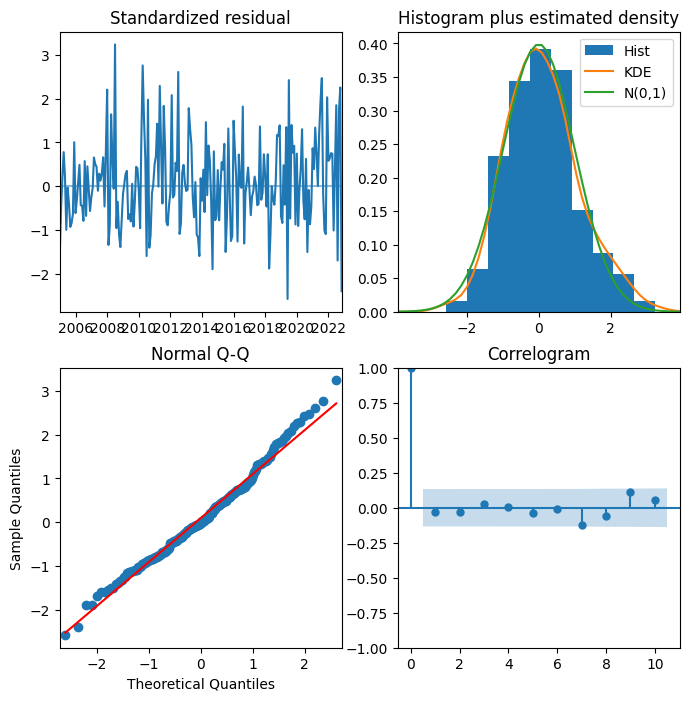

In [11]:
plot_sarima_variable(variable="pp",test= True)